### Start-up

Run this cell cell only befor the first execution, or after you made changes to ```cubes_e2e.py```. 

In [1]:
%run cubes_e2e_refresh.py

Uncomment this cell to enable plot interactivity.

In [2]:
#%matplotlib notebook

Uncomment this cell to perform memory checks.

In [3]:
#%load_ext memory_profiler

Specify a wavelength or a list of wavelengths (in nm) at which the value of the quantities is to be printed on the plots.

In [4]:
test_wave = 386.5

### Input spectra

Select the spectral template for the science target: ```flat``` for a flat spectrum, ```PL``` for a power-law, or ```custom``` for a custom spectrum to be read from a file. If you select ```custom```, please provide the path to the file as well. Wavelengths in the file must be expressed in Angstrom.


**NB**: run this cell if you run the one at the top.

In [5]:
sim.spec_templ = 'custom'  # Template 
sim.spec_file = 'Science_Spectra/QSO_composite.dat'  # Path to file

Specify the minimum and maximum wavelength to cut the spectrum.

**NB**: the range should fall within the wavelength span of the template, but large enough to cover all the instrument's arm (see below).

In [6]:
sim.wmin = 300 * au.nm  # Minimum wavelength
sim.wmax = 410 * au.nm  # Maximum wavelength

Specify the ```AB``` or ```Vega``` magnitude of the target in a given photometric band. Available bands are Johnson ```U```, ```B```, and ```V```. The magnitude will be converted into a photon flux density in the band and use to rescale the spectral template.

**NB**: be sure that the band you choose is wholly covered by your spectral template.

In [7]:
sim.mag_syst = 'Vega'  # System
sim.mag_band = 'B'  # Band
sim.targ_mag = 21  # Magnitude

Only for extragalactic spectra: provide an emission redshift and chose how to model the IGM absorption (```simple``` for a simple integration of the Lyman-alpha curve of growth; ```inoue``` for the more accurate formulae from Inoue et al. 2014, covering all the Lyman series).

**NB**: Be sure that ```zem``` is set to ```None``` if you are **not** using an extragalactic spectrum.

In [8]:
sim.zem = 2.0  # Emission redshift
sim.igm_abs = 'inoue'  # IGM absorption

Adjust the atmospheric parameters and compute the spectrum of the sky background with SkyCalc. If any of these values is ```None```, a pre-computed background will be used (with ```airmass``` = 1.16, ```pwv``` = 2.5, ```moond``` = 0).

**NB**: SkyCalc execution may be time consuming.

In [9]:
sim.airmass = 1.16  # Airmass
sim.pwv = 2.5 # Precipitable water vapor
sim.moond = 0  # Days from new moon

Finally, plot the input spectra of target and background for a given exposure time. Optionally save the target spectrum in a format accepted by the CUBES ETC 

**NB**: to properly save the spectrum, ```sig.mag_syst``` and ```sig.mag_band``` above must be ```Vega``` and ```V```, respectively. ```sim.qso_zem``` must be above 1 to have enough flux in the Vega V band (and avoid normalization issues).

Photons collected.
Input spectra created.
Target magnitude: U_Vega: 20.064; V_Vega: 20.858.
Sky spectrum and atmospheric extinction computed by SkyCalc.
Background magnitude (per arcsec^2): U_Vega: 22.024; V_Vega: 21.742.


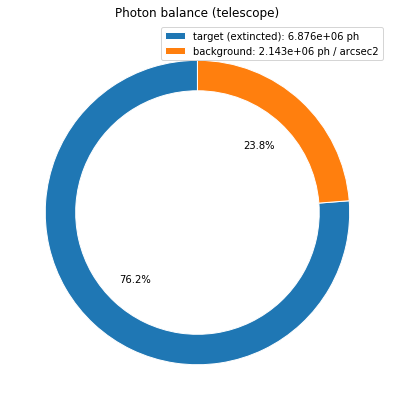

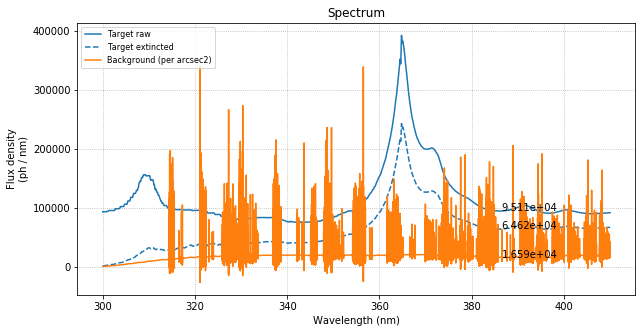

In [10]:
sim.texp = 3600*au.s  # Exposure time
sim.spec_in(test_wave)
#%mprun -f sim.spec_in sim.spec_in()  # Only for memory checks

### PSF and slices

Define a function for the PSF of the target in the sky (```tophat```  or ```gaussian```). The ```seeing``` parameters provides the radius of the ```tophat``` function or the FWHM of the ```gaussian``` function.

In [11]:
sim.psf_func = 'gaussian'  # Function to represent the PSF
sim.seeing = 0.87*au.arcsec  # Seeing

If the target is extended, choose a suitable profile (```invrad``` for inverse-radius profile, ```sersic``` for a Sersic profile) and tune its parameters. In the case of an extended target, the magnitude defines the number of photons within the effective radius ```r_eff```. The parameters for the Sersic profile are those defined for the [Astropy class ```Sersic2D```](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Sersic2D.html#astropy.modeling.functional_models.Sersic2D.evaluate).

In [12]:
sim.targ_prof = None
sim.targ_invrad_params = {'r_eff': 2}
sim.targ_sersic_params = {'amplitude': 1, 'r_eff': 2, 'n': 4, 'x_0': 0.5, 'y_0': 0.5, 'ellip': 0.5, 'theta': 1} 

Design the slices onto the PSF, specifying their number and size.

Slices designed on field.     


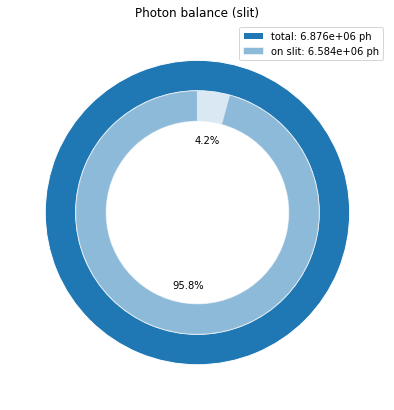

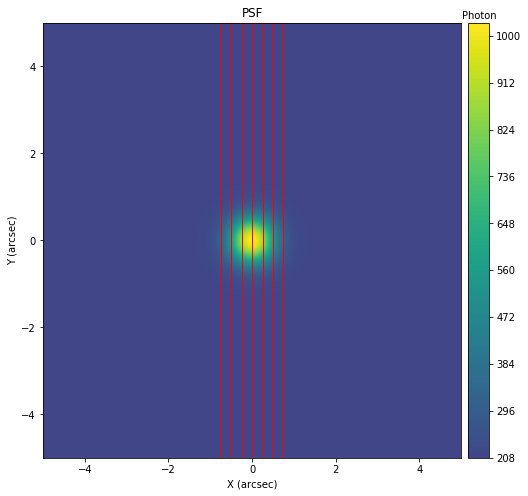

In [13]:
sim.slice_n = 6  # Number of slices
sim.slice_length = 10*au.arcsec  # Length of the slice
sim.slice_width = 0.25*au.arcsec  # Width of the slice
sim.psf()
#%mprun -f sim.psf sim.psf()  # Only for memory checks

### Spectral format

Specify the characteristics of the CCDs, including the size and binning of pixels.

**NB**: The CCDs are assumed to be identical in all arms.

In [14]:
sim.ccd_gain = 1.1*au.photon/au.adu  # Gain (i.e. conversion from ADU to photons)
sim.ccd_ron = 2.5*au.photon / sim.ccd_gain  # Read-out noise (in ADU)
sim.ccd_dark = 3*au.photon/au.h / sim.ccd_gain  # Dark current (in ADU per unit time)
sim.ccd_xsize = 6144*au.pixel  # X size of the CCD 
sim.ccd_ysize = 6144*au.pixel  # Y size of the CCD
sim.pix_xsize = 15*au.micron  # X size of the pixels
sim.pix_ysize = 15*au.micron  # Y size of the pixels
sim.ccd_xbin = 1  # X binning of the CCD
sim.ccd_ybin = 1  # Y binning of the CCD

Choose the number of arms (2 or 3). Optimal values for the dichroich wavelength(s) and the shift of the CCD edges with respect to the dichroich wavelength(s) for a 6k × 6k CCD are given, but you can fine-tune them too (especially if you choose a different CCD size).

In [15]:
sim.arm_n = 2  # Number of arms
if sim.arm_n == 1:
    sim.wave_d = []*au.nm  # Wavelength of dichroich
if sim.arm_n == 2:
    sim.wave_d = [349]*au.nm  # Wavelength of dichroich
    sim.wave_d_shift = 0*au.nm  # Shift of the CCD edges w.r.t. the dichroich wavelength
if sim.arm_n == 3 and sim.ccd_ysize.value < 5000:
    sim.wave_d = [334, 364]*au.nm  # Wavelengths of dichroichs
    sim.wave_d_shift = 12*au.nm  # Shift of the CCD edges w.r.t. the dichroich wavelengths
if sim.arm_n == 3 and sim.ccd_ysize.value > 5000:
    sim.wave_d = [340, 380]*au.nm  # Wavelengths of dichroichs
    sim.wave_d_shift = 12*au.nm  # Shift of the CCD edges w.r.t. the dichroich wavelengths

Efficiencies and dispersion are loaded from static files in directory ```database```. Efficiencies are loaded from  ```EFF_nARM_mCH``` (with ```n``` the number of arms and ```m``` the ordinal of each arm), while dispersion is loaded from file ```DISPERSION```. Edit those files only if needed. Then define the spatial scale.

**NB**: The sampling in the dispersion file is the wavelength range of **non-binned** pixels. It will be converted internally to the wavelength range of binned pixels.

In [16]:
sim.spat_scale = 0.25*au.arcsec/(30*au.micron)  # Spatial scale

Finally, set a value for the gap between the slices and display the spectral format.

**NB**: The sampling in the plot is that of **binned** pixels.

Slices projected onto arms.       


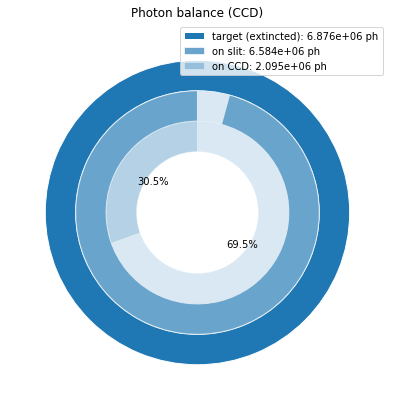

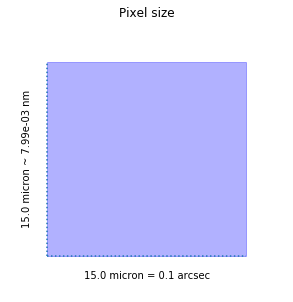

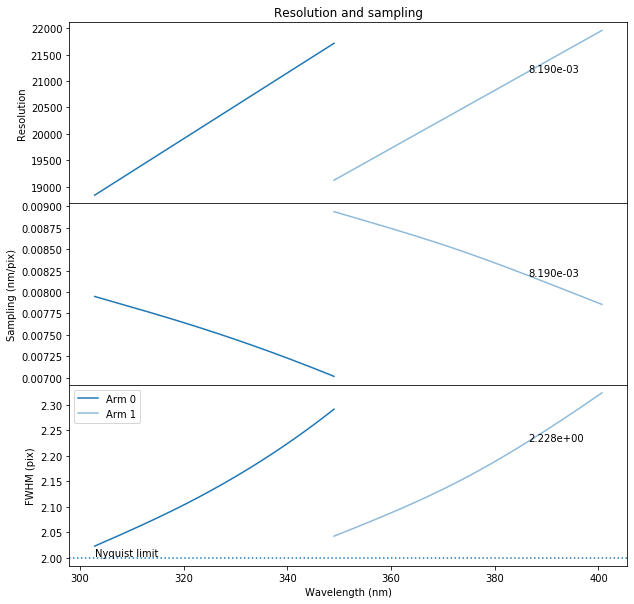

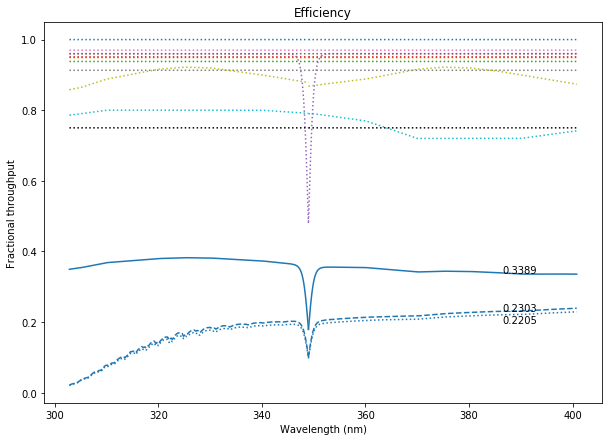

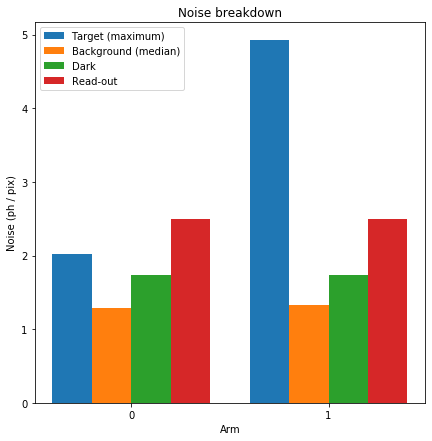

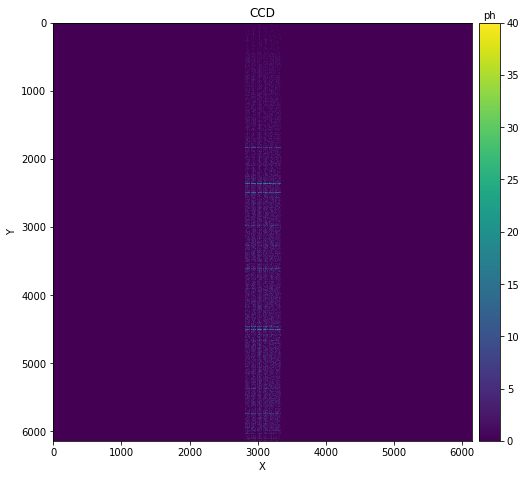

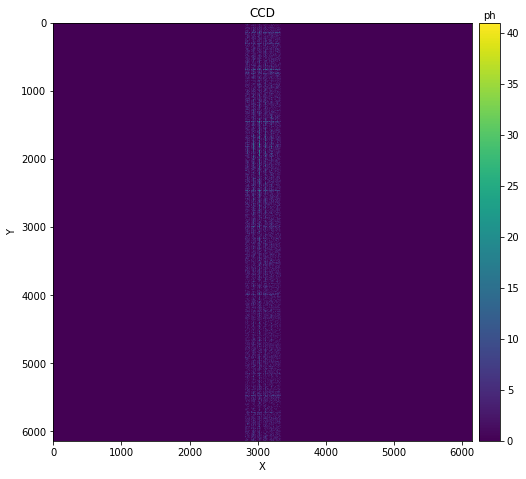

In [17]:
sim.slice_gap = 10*au.pixel  # Gap between the slices
sim.ccd(test_wave)
#%mprun -f sim.ccd sim.ccd()  # Only for memory checks

### Output spectrum

Select the extraction method: ```sum``` for a simple boxcar summation, ```opt``` for Horne-like optimal extraction. In case of ```sum```, you can also specify the number of FWHMs around the object traces over which extraction is carried out. 

NB: ```opt``` has not been thoroughly tested and is very time-consuming.

In [18]:
sim.extr_func = 'sum'  # Function for extracting the spectrum
sim.extr_fwhm_num = 1.2   # Number of FWHMs used in 'sum' extraction

Choose the sampling to compute the signal-to-noise ratio on the extracted spectrum.

In [19]:
sim.snr_sampl = 1*au.nm  # Data points per SNR point

Finally, extract the spectrum and display it:

SNR across arm 0:               
 304.99 nm:   2
 313.00 nm:   3
 320.66 nm:   3
 336.33 nm:   3
 352.01 nm:   1
SNR across arm 1:               
 345.99 nm:   3
 359.50 nm:   7
 373.00 nm:  10
 386.51 nm:   7
 400.01 nm:   6

Summary (to compare with MGE's reference values):

 - Atmosphere efficiency:             0.679
 - Slit efficiency:                   0.958
 - Instrument efficiency:             0.452
 - Telescope efficiency:              0.750
 - Total efficiency (for target):     0.221
 - Total efficiency (for background): 0.339

 - Exposure time:    3.600e+03 s
 - Telescope area:   5.17540e+05 cm2
 - Test wavelength:  3.865e+02 nm
 - Sampling (d-lam): 8.190e-03 nm / pix

 - Target flux:
    - density, raw       (OBJ F0):    5.105e-06 ph / (Angstrom cm2 s)
    - density, extincted (OBJ F1):    3.468e-06 ph / (Angstrom cm2 s)
    - density, on CCD    (OBJ F2):    1.126e-06 ph / (Angstrom cm2 s)
    - collected, on CCD  (OBJ F3):    2.097e+03 ph / Angstrom
    - integrated, on CCD

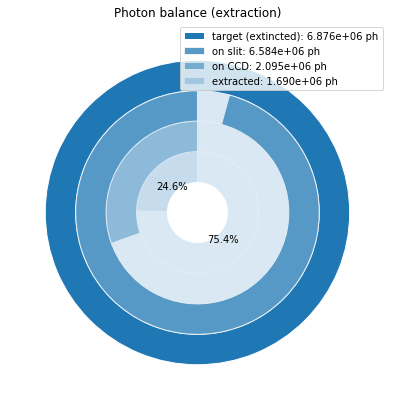

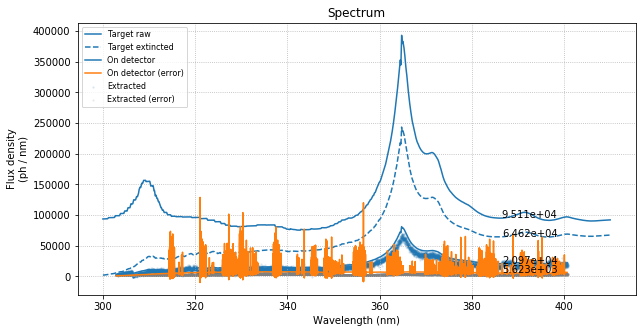

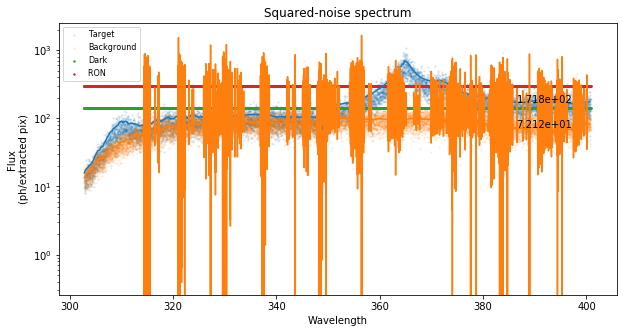

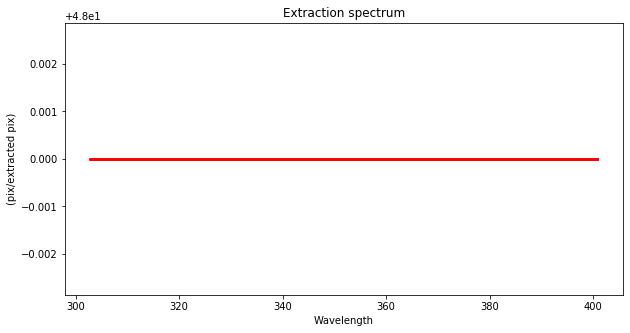

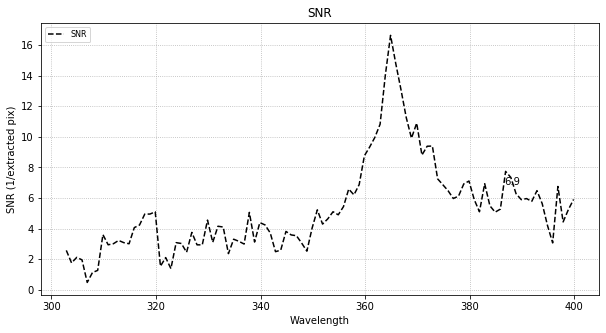

In [20]:
sim.spec_draw(test_wave)
#%mprun -f sim.spec_draw sim.spec_draw()  # Only for memory checks